# Part 6.3 - Analysis Topic Model of WWI
---
### Papers Past Topic Modeling
<br/>

Ben Faulks - bmf43@uclive.ac.nz

Xiandong Cai - xca24@uclive.ac.nz

Yujie Cui - ycu23@uclive.ac.nz

In [1]:
import sys, gc
sys.path.insert(0, '../utils')
from utils import filter_topics, plot_topics
import pandas as pd
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', 120)
from sklearn.preprocessing import MinMaxScaler
from wordcloud import WordCloud
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')
sns.axes_style("darkgrid")
%matplotlib inline
dpi=80

import datetime
print (datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2019-02-01 15:22:24


**In this part, we will use the topic modeling result from part 6.1 to analyze the WWI time.** 

**To evaluate and compare the distribution of topics, we use two basic metrics, in practice we use both to find interesting topics:**
1. The dominant topic counts. 

    Every document has a dominant topic represent the most portion of its contents. By summing the number of each dominant topic in a range of time, we see the variety and trend of each topic over time. It is easy to understand and fit for scatter plot, but in this way it ignores  non-dominant topics.

1. The average weight of topics over time.

    This metric is the average weight of a topic through all documents in a range of time, it avoid the issue above, reflect the topic variety and trend over time. However, it might give a frequent/normal topic (which has a small weight in each document) a high weight because the topic appears in large number of documents, when sum all weights of each topic and divid by total weight of all topics, this normal topic may get a high weight.
    

**To visualize the topics, we use all or part of below plots:**

1. word cloud to display topic words.

1. Scatter plot to dispaly the dominant tpics distribution over time.

1. Bar chart to display the dominant topics count over time.

1. Point plot to display the average topic weight over time.

## 1 Load dataframes

**Load the processed dataframes:**
* `topicKeys.txt`: topic words list
* `domTopic.csv`: document dominant topics dataframe
* `avgWeight.csv`: average topic weight dataframe

**Topics List:**

In [2]:
path = r'../models/wwi/topicKeys.csv'

df_topics = (pd.read_csv(path, 
                         header=None, 
                         index_col=None, 
                         names = ['topic_', 'weight_', 'keywords_'],
                         encoding='utf8')
             .sort_values(by='topic_')
             .reset_index(drop=True))

topics_shape = df_topics.shape

In [3]:
print('Shape of dataframe:', topics_shape)
df_topics.head()

Shape of dataframe: (200, 3)


,topic_,weight_,keywords_
0,0,0.000934,apply wanted good post work experience wellington position wages salary office experienced box required applications...
1,1,0.008231,killed police received people london persons hundred men explosion city women injured thousand number arrested wound...
2,2,0.000287,rooms price section bungalow deposit large modern home street garage kitchenette good sale post terms tram city view...
3,3,0.003139,meeting committee board motion chairman seconded moved thought matter present report carried messrs read resolution ...
4,4,0.003255,sydney south australia melbourne australian wales new_zealand received victoria queensland government federal adelai...


**Docmument - dominant topics dataframe:**

In [4]:
path = r'../models/wwi/domTopics.csv'

df_domtopic = pd.read_csv(path, 
                          header=None, 
                          index_col=None, 
                          names = ['id', 'region', 'year', 'topic', 'weight', 'keywords_'],
                          dtype={2:'str'},
                          encoding='utf8').sort_values(by='id').reset_index(drop=True)

# short keywords for easy plot
df_domtopic['keywords'] = df_domtopic['keywords_'].str.slice(0,60)+'...'
df_domtopic.drop("keywords_", axis=1, inplace=True)

In [5]:
print('Shape of dataframe:', df_domtopic.shape)
df_domtopic.sample(5)

Shape of dataframe: (567878, 6)


,id,region,year,topic,weight,keywords
412336,26334833,Manawatu-Wanganui,1918-02,38,0.124647,tin ill oil day lit zealand mil ton tie hat aro fur aid ail ...
253099,23637863,Manawatu-Wanganui,1914-12,52,0.109533,business public notice orders begs attention stock street go...
304270,24462991,Taranaki,1917-02,63,0.183136,time back man head round left men made long feet side hand n...
78206,15803446,Canterbury,1918-05,63,0.306218,time back man head round left men made long feet side hand n...
207234,18490437,Wellington,1921-06,42,0.394292,time question matter present fact made case position public ...


**Average topic weight dataframe:**

In [6]:
path = r'../models/wwi/avgWeight.csv'

# generate new column names
columns = [str(x) for x in list(range(topics_shape[0]))]
columns.insert(0, 'year')

df_avgweight = pd.read_csv(path, 
                           header=None, 
                           index_col=None, 
                           names = columns,
                           dtype={0:'str'},
                           encoding='utf8')

# melt for plot
df_avgweight = pd.melt(df_avgweight,
                       id_vars='year',
                       value_vars=list(df_avgweight.columns[1:]),
                       var_name='topic',
                       value_name='weight')
# change data type
df_avgweight.topic = df_avgweight.topic.astype(int)

# join
df_avgweight = (df_avgweight
                .merge(df_topics, left_on='topic', right_on='topic_')
                .drop('topic_', axis=1)
                .drop('weight_', axis=1)
                .sort_values(by=['year', 'topic'])
                .reset_index(drop=True))

# short keywords for easy plot
df_avgweight['keywords'] = df_avgweight['keywords_'].str.slice(0,60)+'...'
df_avgweight.drop("keywords_", axis=1, inplace=True)

df_topics.columns = ['topic', 'weight', 'keywords']

In [7]:
print('Shape of dataframe:', df_avgweight.shape)
df_avgweight.sample(5)

Shape of dataframe: (24000, 4)


,year,topic,weight,keywords
13837,1917-10,37,0.004661,goods ladies dress hats millinery stock prices department la...
7314,1915-01,114,0.002059,wool sale company agents produce stock sales commission grai...
19502,1920-02,102,0.000946,stock bank buyers sellers new_zealand national sales pref in...
6035,1914-07,35,0.003009,air british naval german ships navy fleet london sea submari...
14375,1917-12,175,0.004132,king prince queen royal duke lord visit majesty day wales lo...


## 2 The Most Distinct Documents

**First of all, check the document with the highest weight topic through all documents, which means the document contains the fewest topics, easy to check the topic by eyes. Most this kind of documents are oversimplified, but it is a simple way to check topics. Here we print the top one of them.**

In [8]:
df_domtopic.sort_values(by='weight', ascending=False).head(3)

,id,region,year,topic,weight,keywords
132612,16494212,West Coast,1919-09,183,0.949722,police man found murder shot arrested men named made house n...
80455,15838631,West Coast,1914-02,93,0.944485,people country men public government law political state par...
137247,16541987,West Coast,1919-06,99,0.931752,books book published illustrated new_zealand library works h...


In [9]:
id_ = df_domtopic.sort_values(by='weight', ascending=False).iloc[0]['id']
id_

16494212

In [10]:
%%bash -s $id_

echo 'Print 1500 characters of document id: '$1
grep -nw ../data/dataset/sample/train/train.csv -e $1 | cut -c1-2000

Print 1500 characters of document id: 16494212
1554631:16494212	TIDES.	TIDES.September 1—2.25 a.m.; 2.47 p.m. September 2—3.9 a.m; 3.34 p.m. September 3—3.56 a.m; 4.22 p.m. September 4—4.47 a.m; 5.15 p.m. September 5—4.45 a.m ; 6.20 p.m. September 6—6.50 a.m; 8.15 p.m. < September 7—7.50 ,v.m; 8.15 p.m. September. 8—8.43 a.m; 9.3 p.m. September 9—9.30 a.m ; 9.57 p.m. September 10—10.15 a.m; 10.38 p.m. -i September 11—10.58 si.m; 11.17 p.m. September 12—11.38 a.m: 11.59 p.m. September 13 ; 0.20 n.m. September 14—0.42 a.m: 1.3 p.m. September 15—1.25 a.m; 1.50 p.m. September 16—2.1.2 a.m: 2.37 p.m. September 17—3.7 n.m; 3.34 p.m. September 18—1.3 a.m; 4.35 p.m. September 19—5.5 a.m; 5.40 i^m. SVntember 20—6.15 .',. m; 6.47 p.m. September 21—7.22 si.nr; 7.50 p.m. September 22—9.25 a.m; 5.50 p.m. September 23—9.20 a.m; 9.45 p.m. September 24—10.12 a.m: 10.37 p.m. September 25—11.0 a.m; 11.20 p.m. September 26—11.43 a.m; September 27—0.4 a.m; 0.24 p.m. September 28—0.49 a.m; 1.10 p.m. Septem

## 3 General Distribution of Topics

### 3.1 Word Cloud

**Since MALLET outputs topic keywords without weight of each keywords, so we will add sequential weight (like arithmetic progression) for each keywords, which means the weight of each keywords is not accurate, but for word cloud it is acceptable. Below plot shows the highest weight 20 topics in topics list.**

In [11]:
df_plt = df_topics.copy(deep=True).sort_values(by='weight')

def addWeight(keywords):
    k = keywords.split()
    s = sum(range(len(k)+1))
    v = [i / s for i in range(len(k), 0, -1)]
    return dict(zip(k, v))

df_plt['cloudwords'] = df_plt['keywords'].map(addWeight)

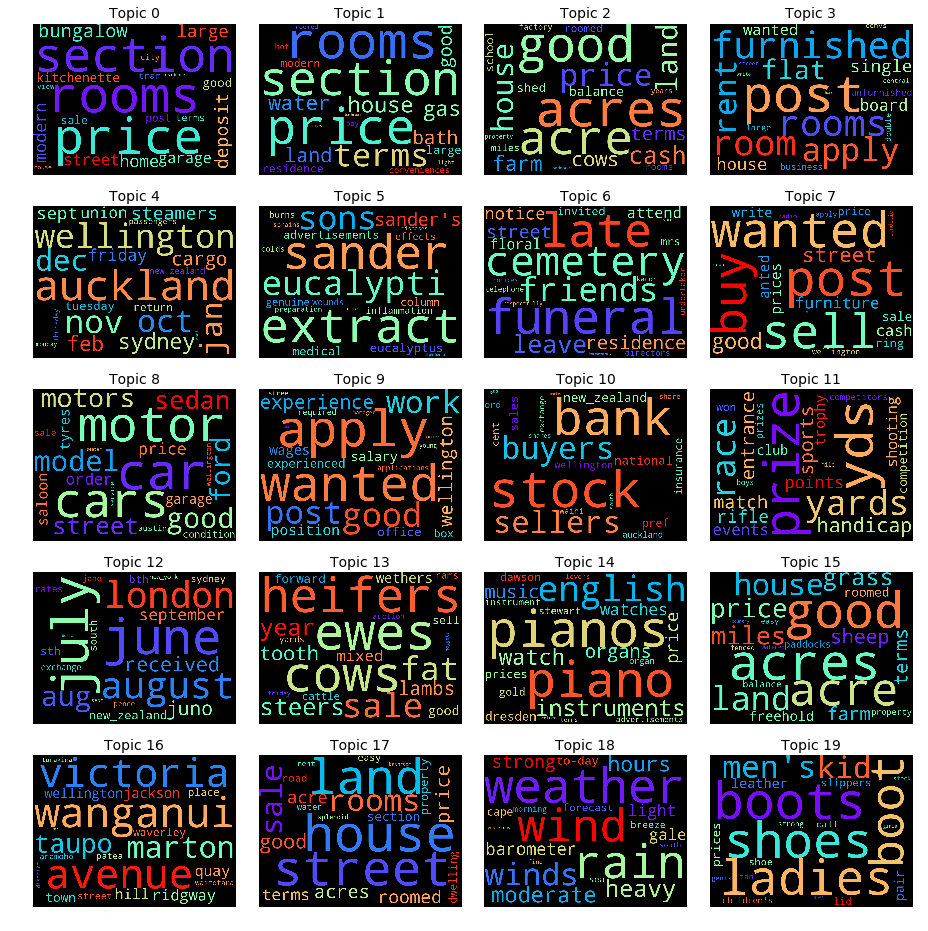

In [12]:
#show_num_topics = df_plt.shape[0]
plt_topics = 20
plt_words  = 20
plt_cols   = 4

cloud = WordCloud(width=800,
                  height=600,
                  max_words=plt_words,
                  colormap='rainbow')

fig, axes = plt.subplots(int(plt_topics/4), plt_cols,
                         figsize=(13,13), 
                         sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    cloud.generate_from_frequencies(df_plt.iloc[i]['cloudwords'],
                                    max_font_size=200)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic {}'.format(i), fontdict=dict(size=14))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### 3.2 Documents Distribution

**Before checking the topic distribution, we should take a look at the documents distribution.**

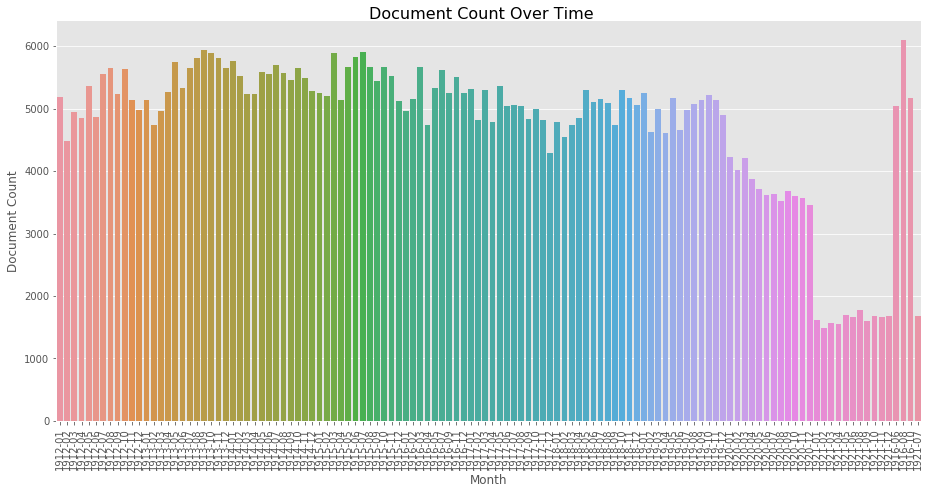

In [13]:
g = sns.catplot(x="year",
                kind='count', height=6.5, aspect=2, 
                dodge=False, legend=False, 
                data=df_domtopic)
g.fig.suptitle("Document Count Over Time", fontsize=16)
g.fig.subplots_adjust(top=0.95)
g.set(xlabel='Month', ylabel='Document Count')        
g.set_xticklabels(rotation=90, step=1)

### 3.3 Dominant Topics Distribution

**We plot all the dominant topics to glimpse the distribution in general, each point represents a document in a certainn year with certain dominant topic weight, the color changes over time.**

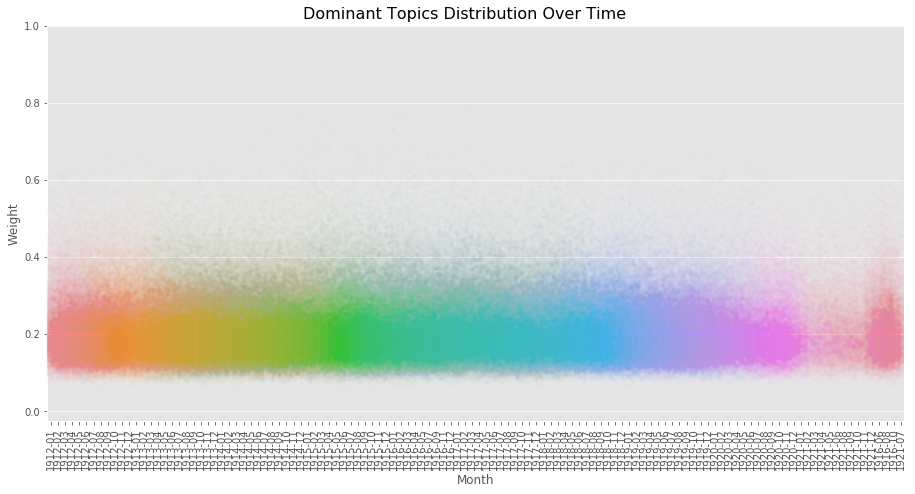

In [14]:
g = sns.catplot(x="year", y='weight',
                kind='strip', height=6.5, aspect=2, 
                jitter=2, dodge=False, 
                s=4, alpha=0.01,
                legend=False,
                data=df_domtopic)

g.fig.subplots_adjust(top=0.94)
g.fig.suptitle("Dominant Topics Distribution Over Time", fontsize=16)
g.set(xlabel='Month', ylabel='Weight')
g.set_xticklabels(rotation=90)

### 3.4 Monthly Average Weight Distribution

**We plot all the monthly average weight to see the general distribution:**

In [15]:
df_plt = df_avgweight[['year', 'topic', 'weight']]

df_plt = pd.pivot_table(data=df_plt,
                        index='topic',
                        values='weight',
                        columns='year')
scaler = MinMaxScaler()
df_plt_scaled = pd.DataFrame(scaler.fit_transform(df_plt),columns = df_plt.columns)
df_plt_scaled.head()

year,1912-01,1912-02,1912-03,1912-04,1912-05,1912-06,1912-07,1912-08,1912-09,1912-10,1912-11,1912-12,1913-01,1913-02,1913-03,1913-04,1913-05,1913-06,1913-07,1913-08,1913-09,1913-10,1913-11,1913-12,1914-01,1914-02,1914-03,1914-04,1914-05,1914-06,1914-07,1914-08,1914-09,1914-10,1914-11,1914-12,1915-01,1915-02,1915-03,1915-04,1915-05,1915-06,1915-07,1915-08,1915-09,1915-10,1915-11,1915-12,1916-01,1916-02,1916-03,1916-04,1916-05,1916-06,1916-07,1916-08,1916-09,1916-10,1916-11,1916-12,1917-01,1917-02,1917-03,1917-04,1917-05,1917-06,1917-07,1917-08,1917-09,1917-10,1917-11,1917-12,1918-01,1918-02,1918-03,1918-04,1918-05,1918-06,1918-07,1918-08,1918-09,1918-10,1918-11,1918-12,1919-01,1919-02,1919-03,1919-04,1919-05,1919-06,1919-07,1919-08,1919-09,1919-10,1919-11,1919-12,1920-01,1920-02,1920-03,1920-04,1920-05,1920-06,1920-07,1920-08,1920-09,1920-10,1920-11,1920-12,1921-01,1921-02,1921-03,1921-04,1921-05,1921-06,1921-07,1921-08,1921-09,1921-10,1921-11,1921-12
0,0.010081,0.006211,0.011124,0.017511,0.010274,0.007209,0.030819,0.018500,0.011235,0.009285,0.007968,0.012313,0.012774,0.012029,0.008522,0.010679,0.007494,0.008384,0.029254,0.014240,0.011335,0.009687,0.012858,0.008926,0.012329,0.006338,0.009628,0.008848,0.009733,0.009862,0.021259,0.010196,0.004077,0.008727,0.006017,0.004880,0.004999,0.006721,0.015584,0.008751,0.010790,0.005805,0.033030,0.013108,0.009681,0.005070,0.006565,0.006882,0.007317,0.011707,0.003262,0.006299,0.004633,0.009308,0.021136,0.009160,0.004505,0.005581,0.007835,0.002271,0.005515,0.010754,0.004273,0.006964,0.006254,0.004278,0.026608,0.009431,0.003829,0.006989,0.003873,0.004943,0.004592,0.007352,0.007812,0.003651,0.009443,0.007389,0.022862,0.012523,0.005585,0.005229,0.005731,0.005690,0.007267,0.007832,0.005242,0.005287,0.007739,0.006400,0.025105,0.010231,0.006384,0.004942,0.004946,0.005170,0.006340,0.008780,0.008760,0.006553,0.005442,0.004741,0.016012,0.011994,0.006488,0.006624,0.005151,0.004877,0.007348,0.003479,0.003992,0.000952,0.004665,0.010462,0.024149,0.014168,0.007368,0.006063,0.003191,0.006074
1,0.125454,0.111910,0.183485,0.128715,0.116664,0.106459,0.121249,0.122566,0.255148,0.116830,0.107028,0.112939,0.121889,0.099251,0.193458,0.140221,0.113687,0.106625,0.129603,0.142679,0.264543,0.128041,0.118063,0.101363,0.117305,0.119737,0.205918,0.137385,0.120248,0.110135,0.131111,0.102856,0.198470,0.098057,0.087224,0.082398,0.088545,0.084629,0.166227,0.098040,0.087722,0.077204,0.084732,0.102015,0.203781,0.094281,0.094889,0.085066,0.097593,0.088037,0.142166,0.095900,0.081994,0.088762,0.072249,0.087297,0.188153,0.084112,0.078437,0.093235,0.086113,0.074610,0.148487,0.086768,0.078434,0.074814,0.082854,0.095813,0.165872,0.081241,0.083922,0.076801,0.083783,0.073888,0.151083,0.077298,0.079491,0.069680,0.076608,0.068519,0.179449,0.093911,0.105135,0.092667,0.087983,0.091232,0.169828,0.102712,0.094165,0.096864,0.100542,0.098537,0.194994,0.095488,0.106293,0.088826,0.095583,0.094021,0.146501,0.111902,0.094204,0.087327,0.091693,0.104680,0.189201,0.107199,0.100940,0.099002,0.082549,0.101205,0.134444,0.094342,0.085907,0.083047,0.087682,0.108803,0.139339,0.100401,0.076081,0.077635
2,0.001636,0.000000,0.000000,0.000000,0.000290,0.000128,0.000457,0.000743,0.001027,0.000000,0.000000,0.000000,0.001298,0.000000,0.000411,0.000882,0.000000,0.000000,0.000171,0.000000,0.000000,0.001254,0.000027,0.002170,0.000000,0.000000,0.000000,0.001254,0.000000,0.000000,0.000000,0.001152,0.000354,0.000000,0.000706,0.000000,0.000919,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001089,0.000542,0.001028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000165,0.000000,0.000000,0.000000,0.000000,0.000609,0.000239,0.000007,0.000012,0.000000,0.000000,0.001819,0.000000,0.001054,0.000000,0.000000,0.000000,0.000000,0.000293,0.000000,0.000700,0.000522,0.000000,0.000000,0.000000,0.000000,0.001514,0.001244,0.000

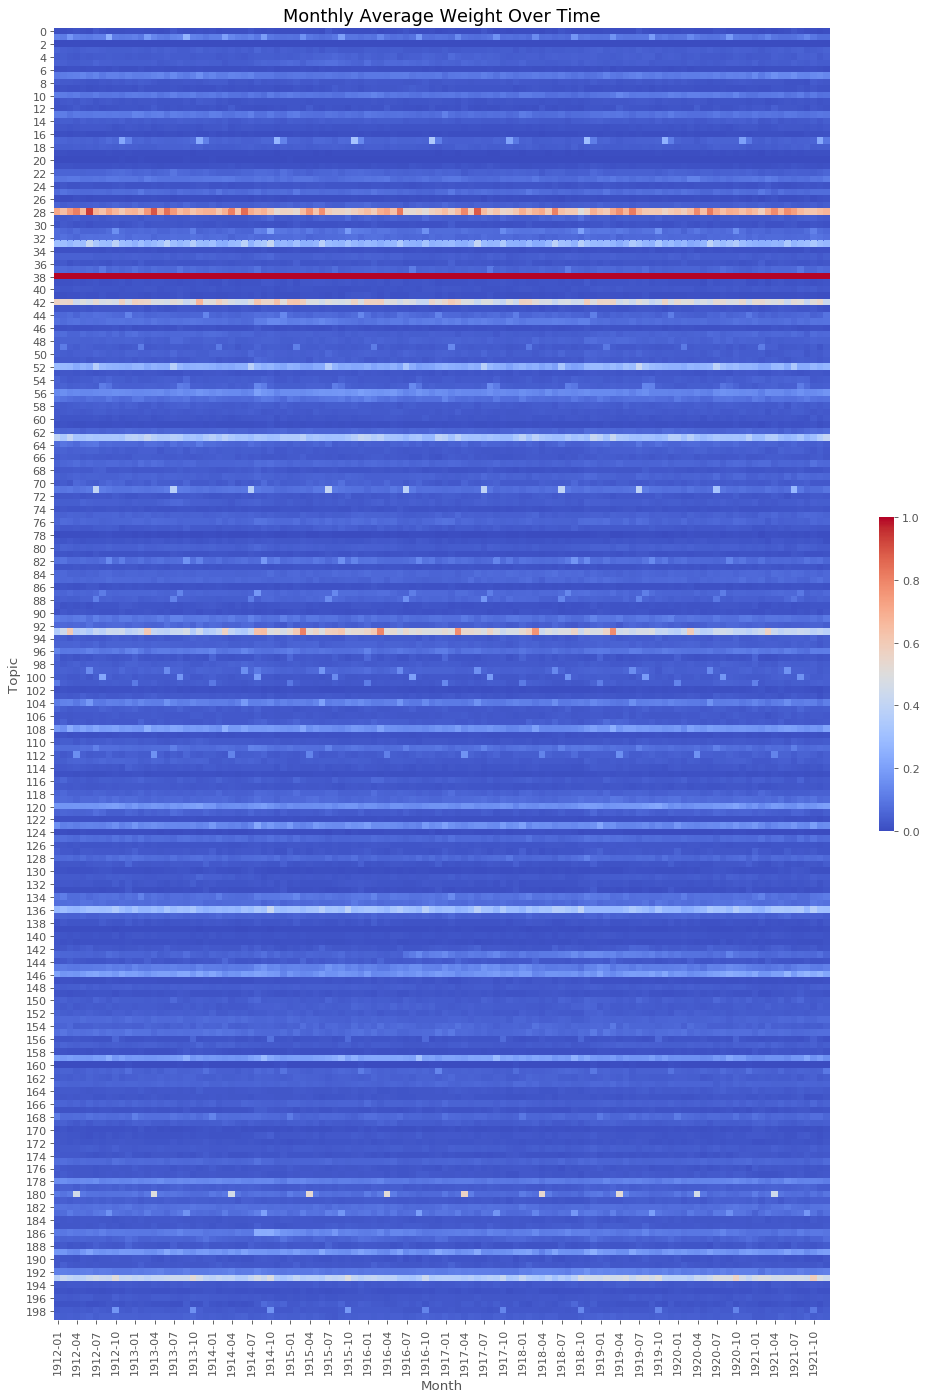

In [16]:
fig, ax = plt.subplots(figsize=(13, 20), dpi=dpi)

sns.heatmap(df_plt_scaled,
            cmap='coolwarm',
            cbar=True,
            cbar_kws={"shrink": .2},
            annot=False,
            square=True,
            ax=ax
            )

plt.xlabel('Month')
plt.ylabel('Topic')
plt.title("Monthly Average Weight Over Time", fontdict=dict(size=16))
plt.xticks(rotation='90')
plt.tight_layout()
plt.show()

### 3.5 Monthly Average Weight of Each Topic

**Plot all topics average weight to check trend of each topic.**

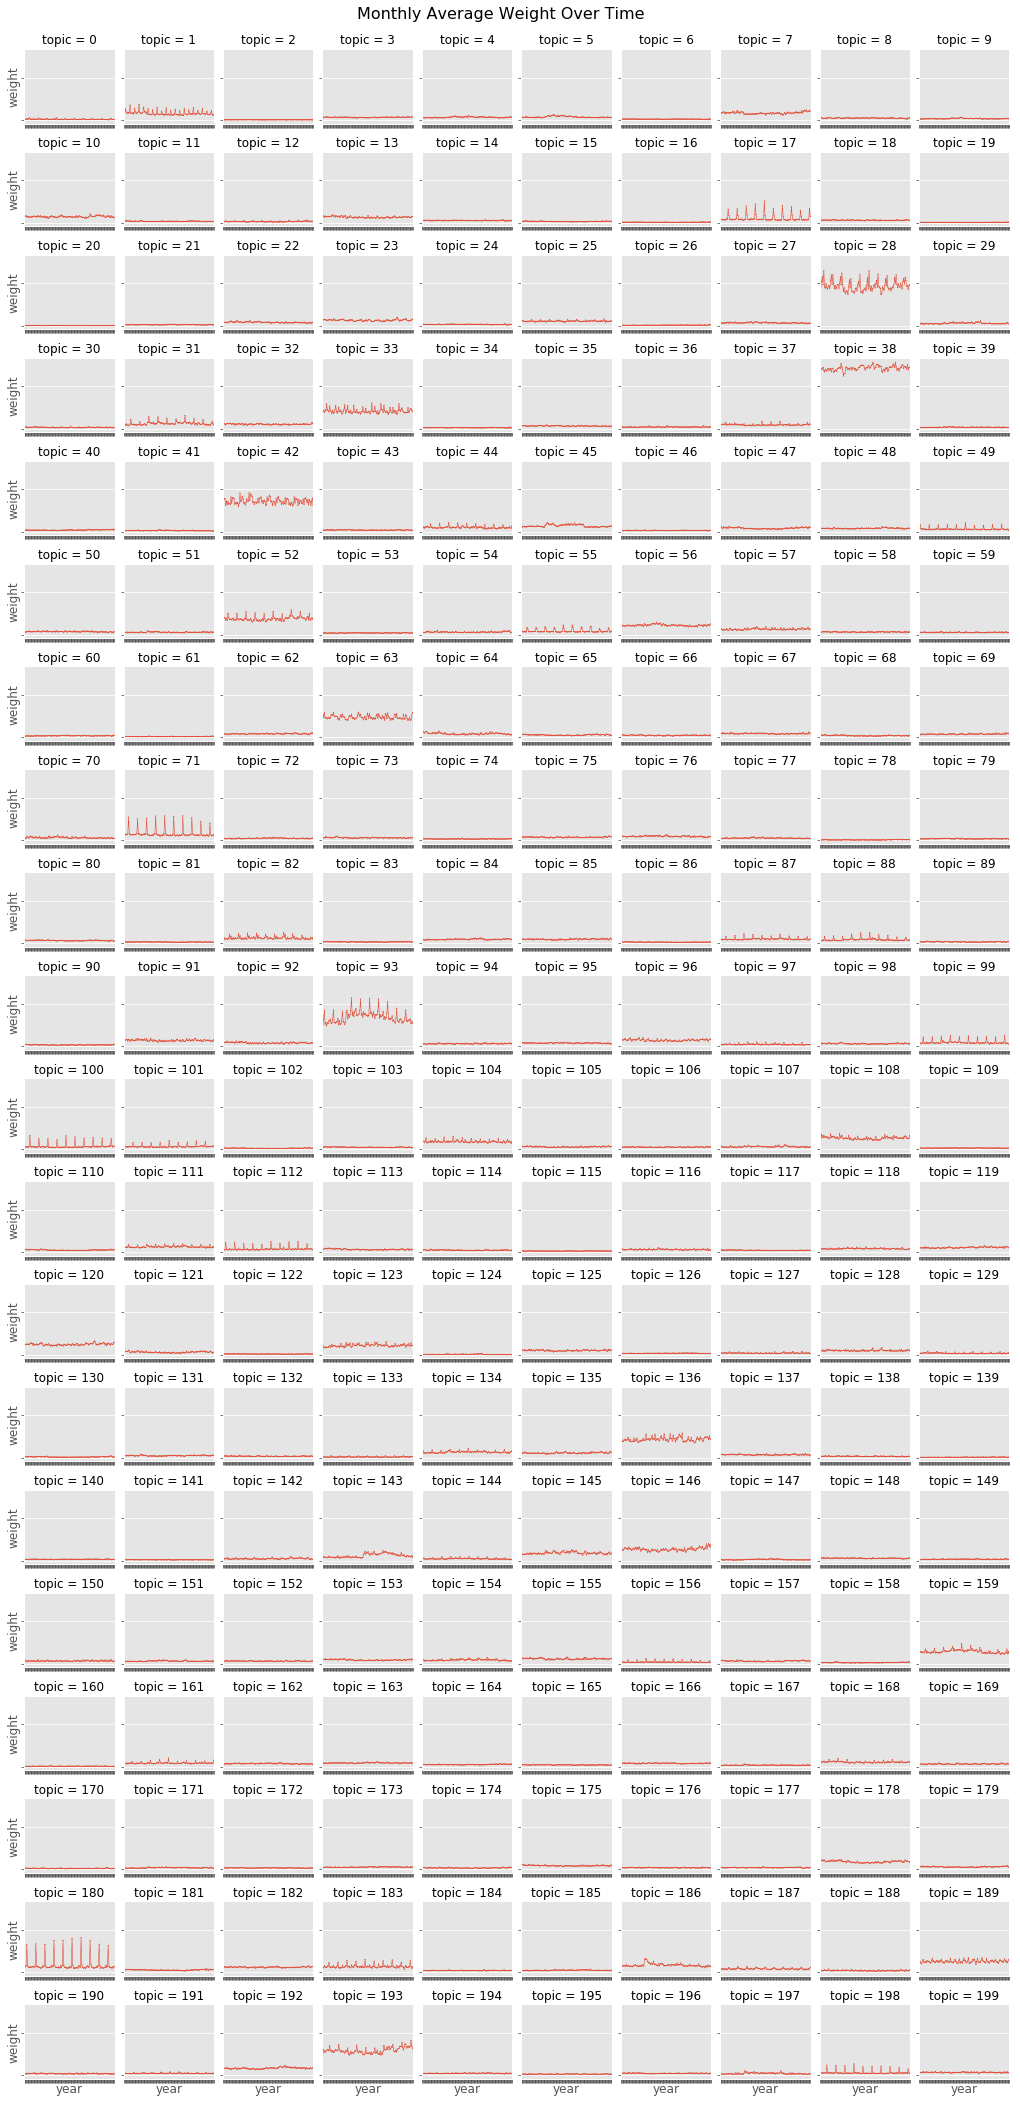

In [17]:
g = sns.catplot(x="year", y='weight',  col='topic', col_wrap=10, 
                kind='point', height=1.5, aspect=1, dodge=False, s=0.2, legend=False, 
                markers='.', scale=0.2,
                data=df_avgweight)
g.fig.suptitle("Monthly Average Weight Over Time", fontsize=16)
g.set_xticklabels(visible=False)
g.set_yticklabels(visible=False)
g.fig.subplots_adjust(top=0.96, hspace=0.4, wspace=0.1)

## 4 The First 10 Topics

**Before we try to find topics with specific features, we plot the first 10 topics to see the situation:**

**Generate dominant topics dataframe for plot:**

In [18]:
topic_list = list(range(10))

print('List of topics to plot:', topic_list)

df_plt_dom = filter_topics(df_domtopic, topic_list)
df_plt_avg = filter_topics(df_avgweight, topic_list)

print('Shape of df_plt_dom:', df_plt_dom.shape)
print('Shape of df_plt_avg:', df_plt_avg.shape)

df_col_order = filter_topics(df_topics, topic_list).set_index('topic')
df_col_order = df_col_order.loc[topic_list]
col_order = df_col_order.keywords.str.slice(0,60)+'...'
df_col_order.head(10)

List of topics to plot: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Shape of df_plt_dom: (10602, 6)
Shape of df_plt_avg: (1200, 4)


,weight,keywords
topic,,
0,0.000934,apply wanted good post work experience wellington position wages salary office experienced box required applications...
1,0.008231,killed police received people london persons hundred men explosion city women injured thousand number arrested wound...
2,0.000287,rooms price section bungalow deposit large modern home street garage kitchenette good sale post terms tram city view...
3,0.003139,meeting committee board motion chairman seconded moved thought matter present report carried messrs read resolution ...
4,0.003255,sydney south australia melbourne australian wales new_zealand received victoria queensland government federal adelai...
5,0.003704,chinese china japanese japan russia russian turkish troops british turkey received government war constantinople lon...
6,0.001032,yds prize yards race handicap sports entrance match rifle points events shooting trophy club competition won prizes ...
7,0.008120,handicap lady furlongs meeting miles mile hack soys king acceptances miss cup gold sir bst royal hurdles day rose club
8,0.002293,reward lost ost white found dog finder apply notice black branded person bay return pound returning office gold satu...


**Dominant topics distribution by month:**

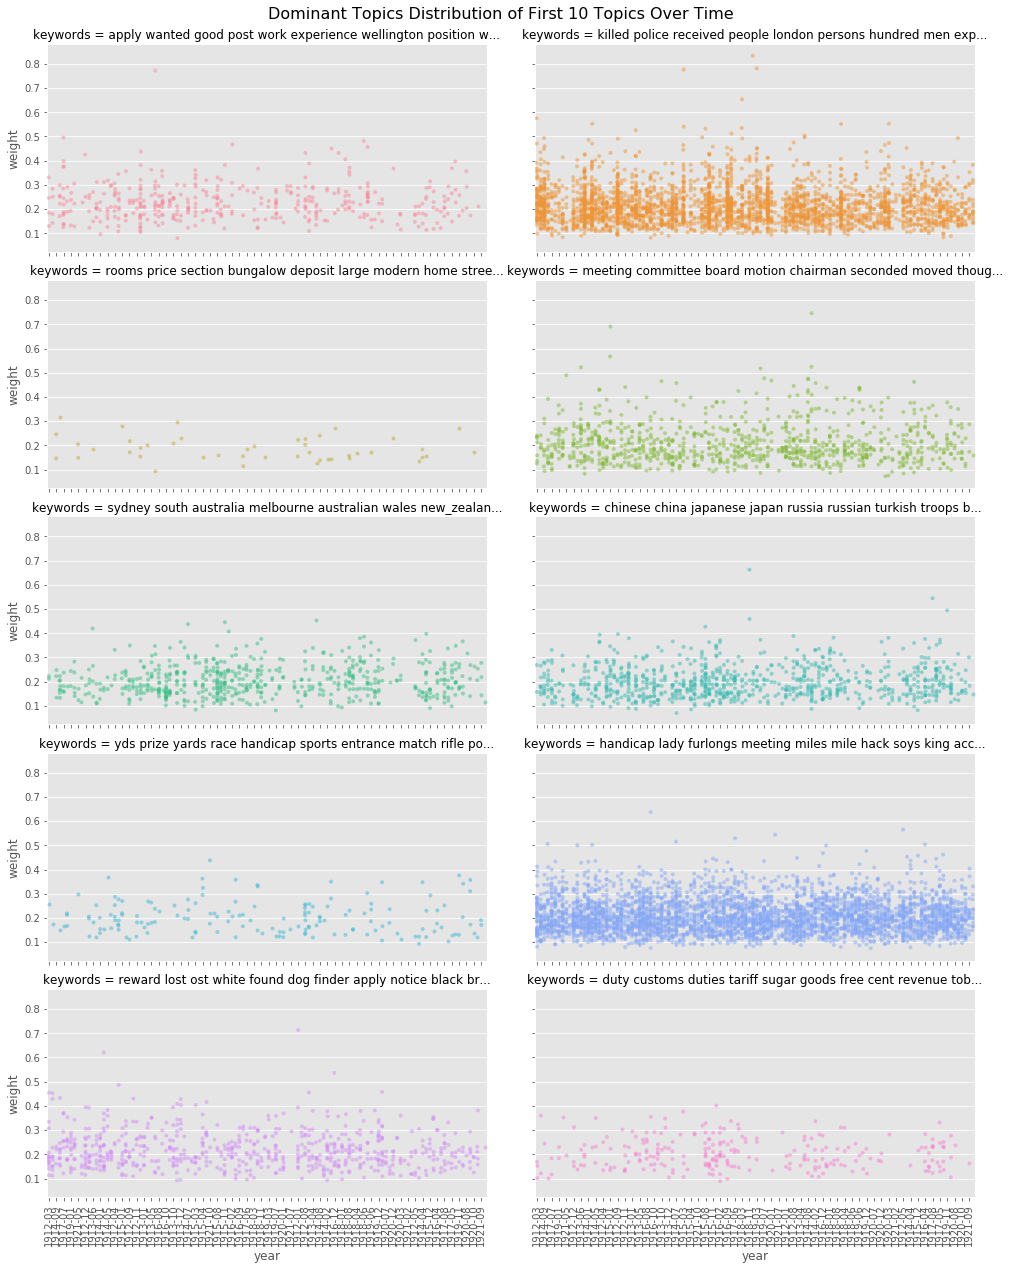

In [19]:
plot_topics(df_plt_dom, 
            'scatter', 
            col_order=col_order,
            adjust_top=0.95,
            title='First 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

**Dominant topics count by month:**

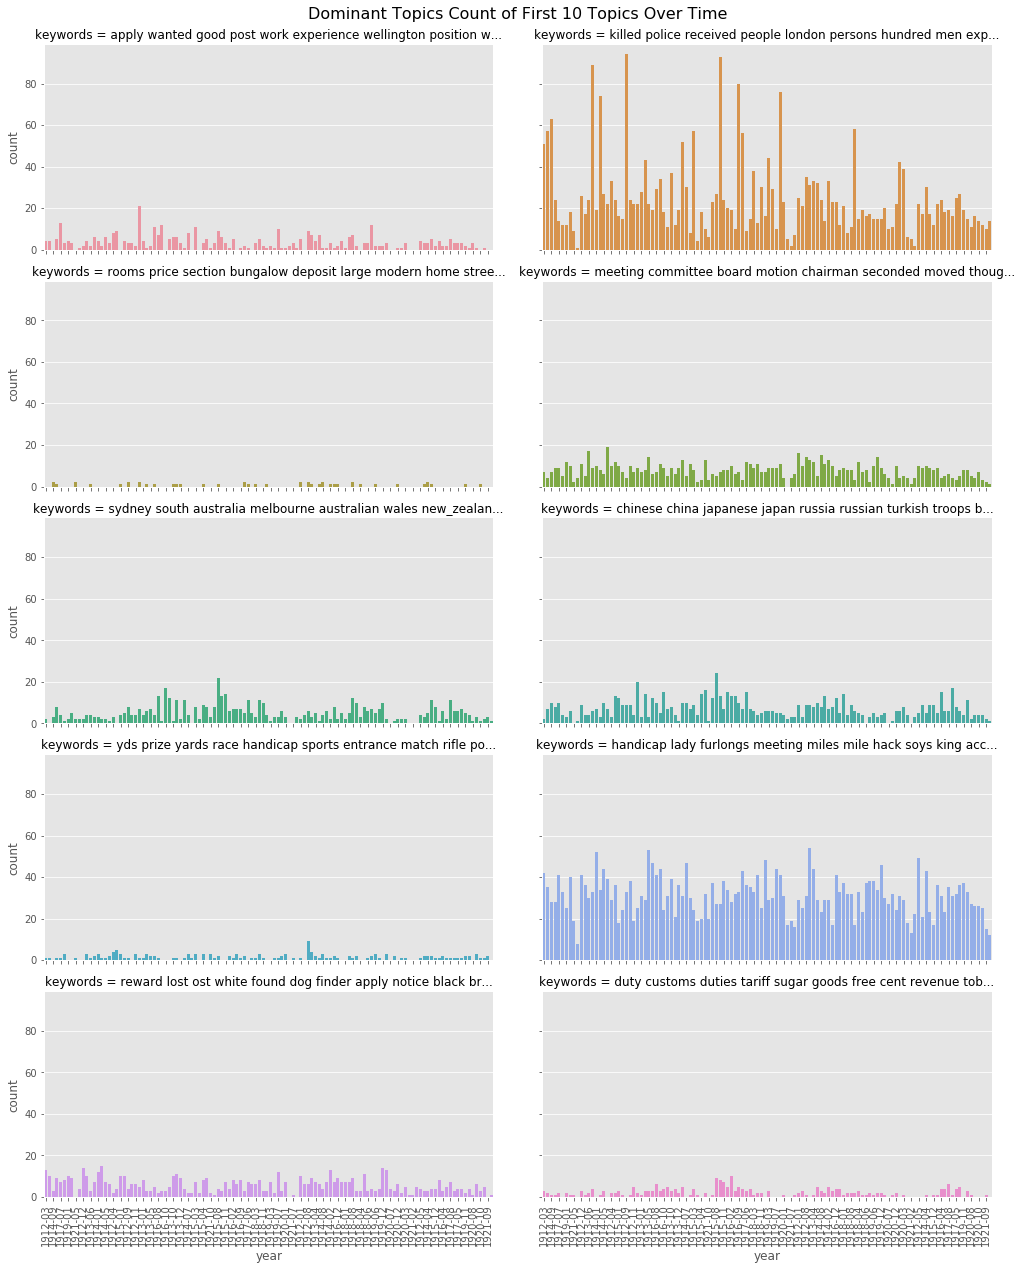

In [20]:
plot_topics(df_plt_dom, 
            'bar', 
            col_order=col_order,
            adjust_top=0.95,
            title='First 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

**Average topic weight by month:**

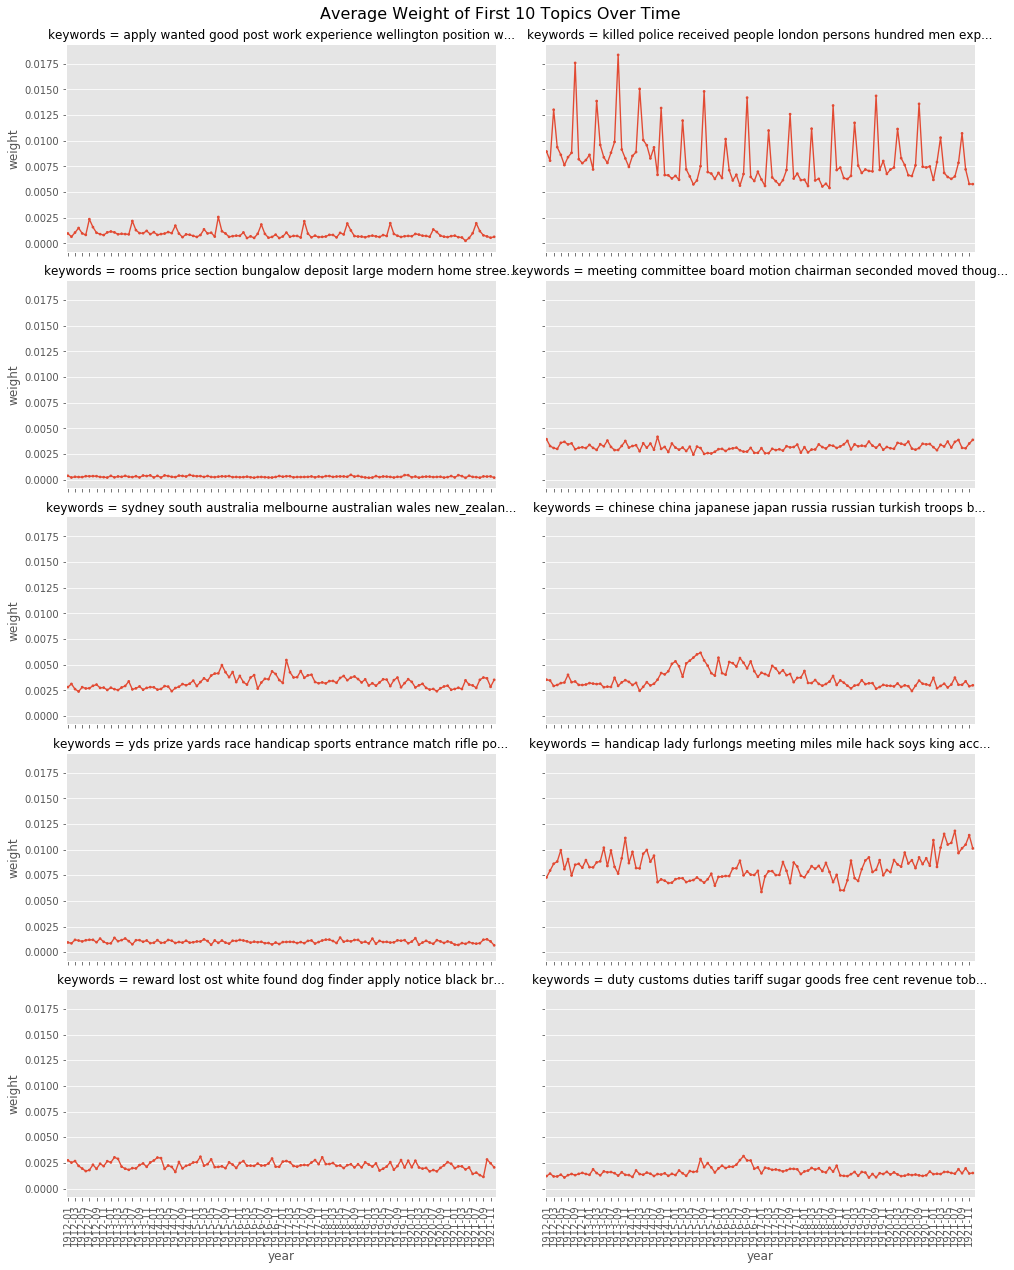

In [21]:
plot_topics(df_plt_avg, 
            'point', 
            col_order=col_order,
            adjust_top=0.95,
            title='First 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

## 5 The Most Significant Topics

**Variance dose not consider the document number, if a topic has high variance but the support documents are few, the topic is not significant. To find significant, we use the figure that dominant topic count multiply the average weight of the topic, this figure considers both the number of support document and the average weight of topic. This way magnifies the topics that are dominant topics of documents, we take it as significant topics.**

In [22]:
df_domtopic_count = (df_domtopic.groupby(['year', 'topic'])
                     .size().reset_index(name='count')
                     .sort_values(['year', 'topic']))
df_domtopic_count.columns = ['year_', 'topic_', 'count']

df_signif = df_avgweight.copy(deep=True)

df_signif = (df_signif
             .merge(df_domtopic_count, left_on=['year', 'topic'], right_on=['year_', 'topic_'], how='outer')
             .sort_values(by=['year', 'topic'])
             .drop(columns=['keywords', 'year_', 'topic_'])
             .reset_index(drop=True)
             .fillna(0))

df_signif['value'] = df_signif['weight'] * df_signif['count']

topic_list = list(df_signif.groupby('topic')['value'].std().sort_values(ascending=False).index[:10])

print('List of topics to plot:', topic_list)

df_plt_dom = filter_topics(df_domtopic, topic_list)
df_plt_avg = filter_topics(df_avgweight, topic_list)

print('Shape of df_plt_dom:', df_plt_dom.shape)
print('Shape of df_plt_avg:', df_plt_avg.shape)

df_col_order = filter_topics(df_topics, topic_list).set_index('topic')
df_col_order = df_col_order.loc[topic_list]
col_order = df_col_order.keywords.str.slice(0,60)+'...'
df_col_order.head(10)

List of topics to plot: [28, 38, 93, 42, 193, 180, 136, 63, 33, 71]
Shape of df_plt_dom: (317999, 6)
Shape of df_plt_avg: (1200, 4)


,weight,keywords
topic,,
28,0.046953,man good people time day men money make thing young put business told things made long great give back poor
38,0.071145,tin ill oil day lit zealand mil ton tie hat aro fur aid ail end tins man hut time win
93,0.034659,people country men public government law political state party man great power system question good present time pol...
42,0.035941,time question matter present fact made case position public great doubt opinion good make point part reason subject ...
193,0.028900,life love god heart day thy man world great thou men death long light thee earth eyes home sweet land
180,0.008679,london sold powder medicines wholesale medical public oil sauce agents genuine chemist prepared chemists medicine bo...
136,0.021819,life man men great world work people good human time mind nature things years knowledge subject character make fact ...
63,0.023959,time back man head round left men made long feet side hand night great ground body face found place hands
33,0.021017,years london great england english year ago time made world lord sir french paris king famous life death found history


**Dominant topics distribution by Month:**

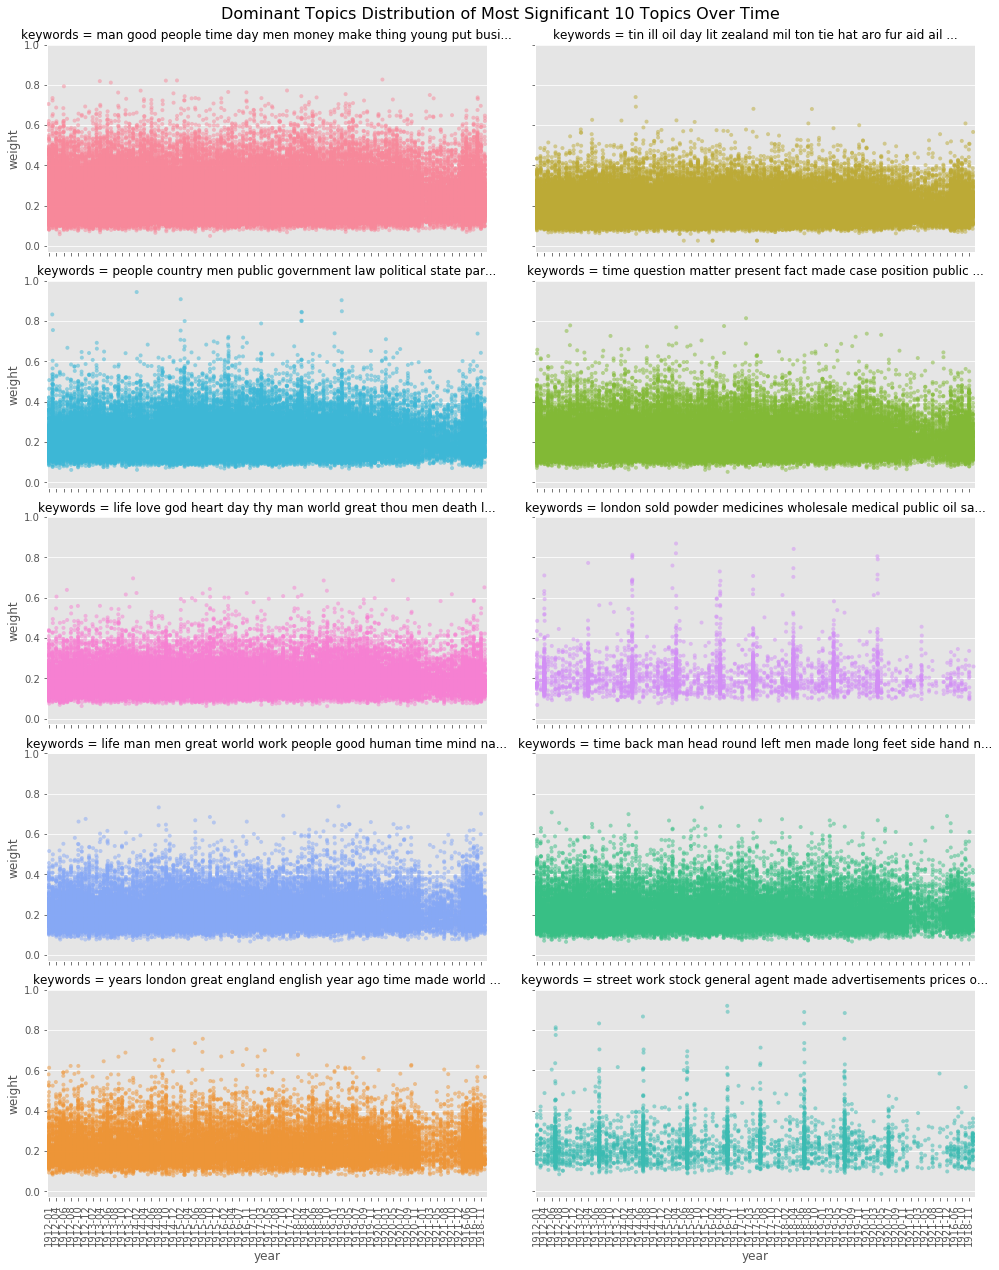

In [23]:
plot_topics(df_plt_dom, 
            'scatter', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

**Dominant topics count by month:**

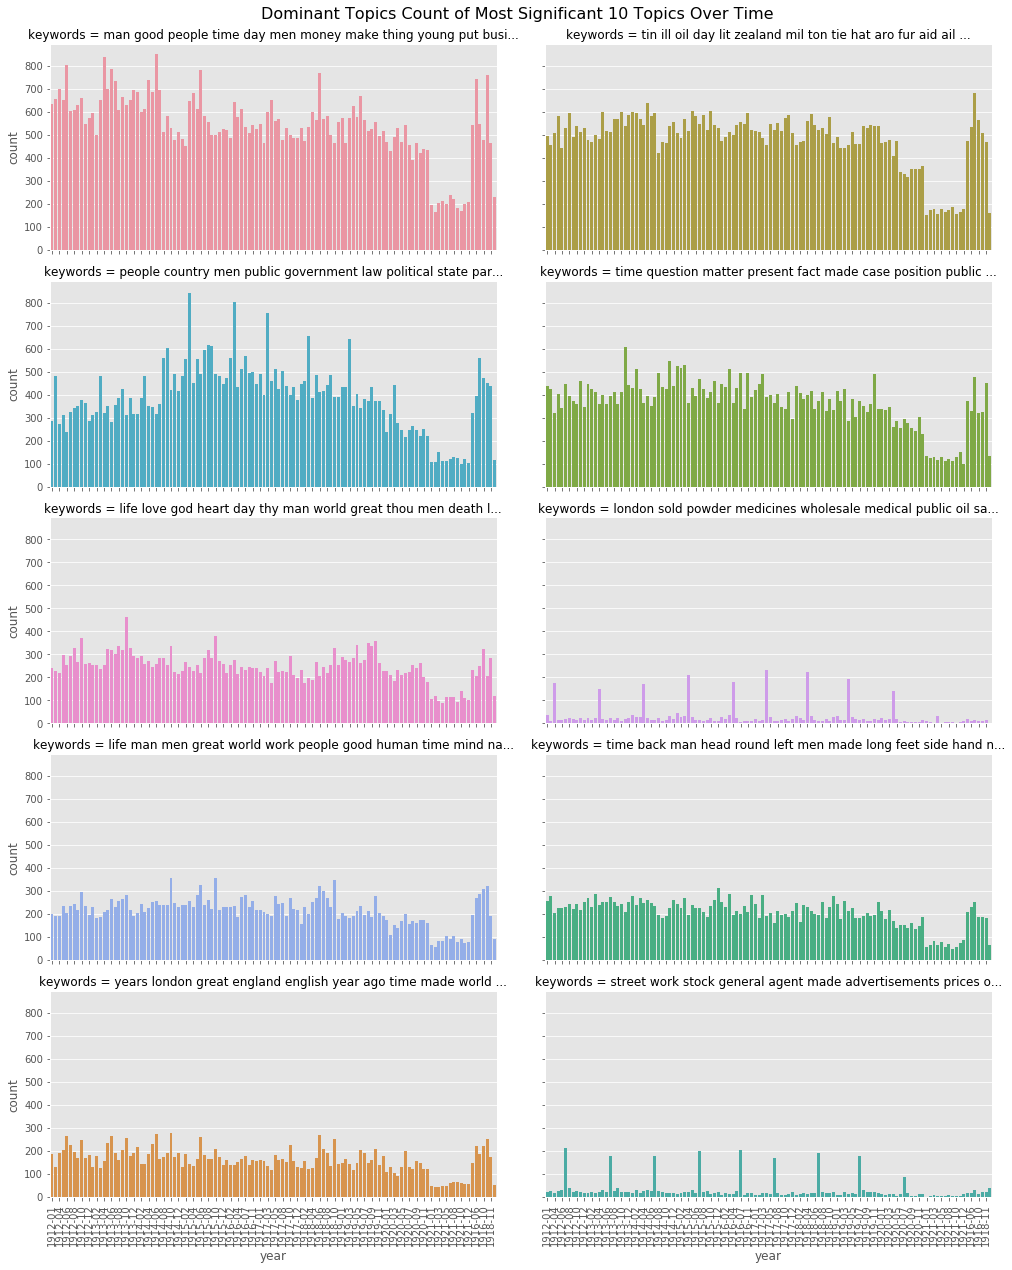

In [24]:
plot_topics(df_plt_dom, 
            'bar', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

**Average topic weight by month:**

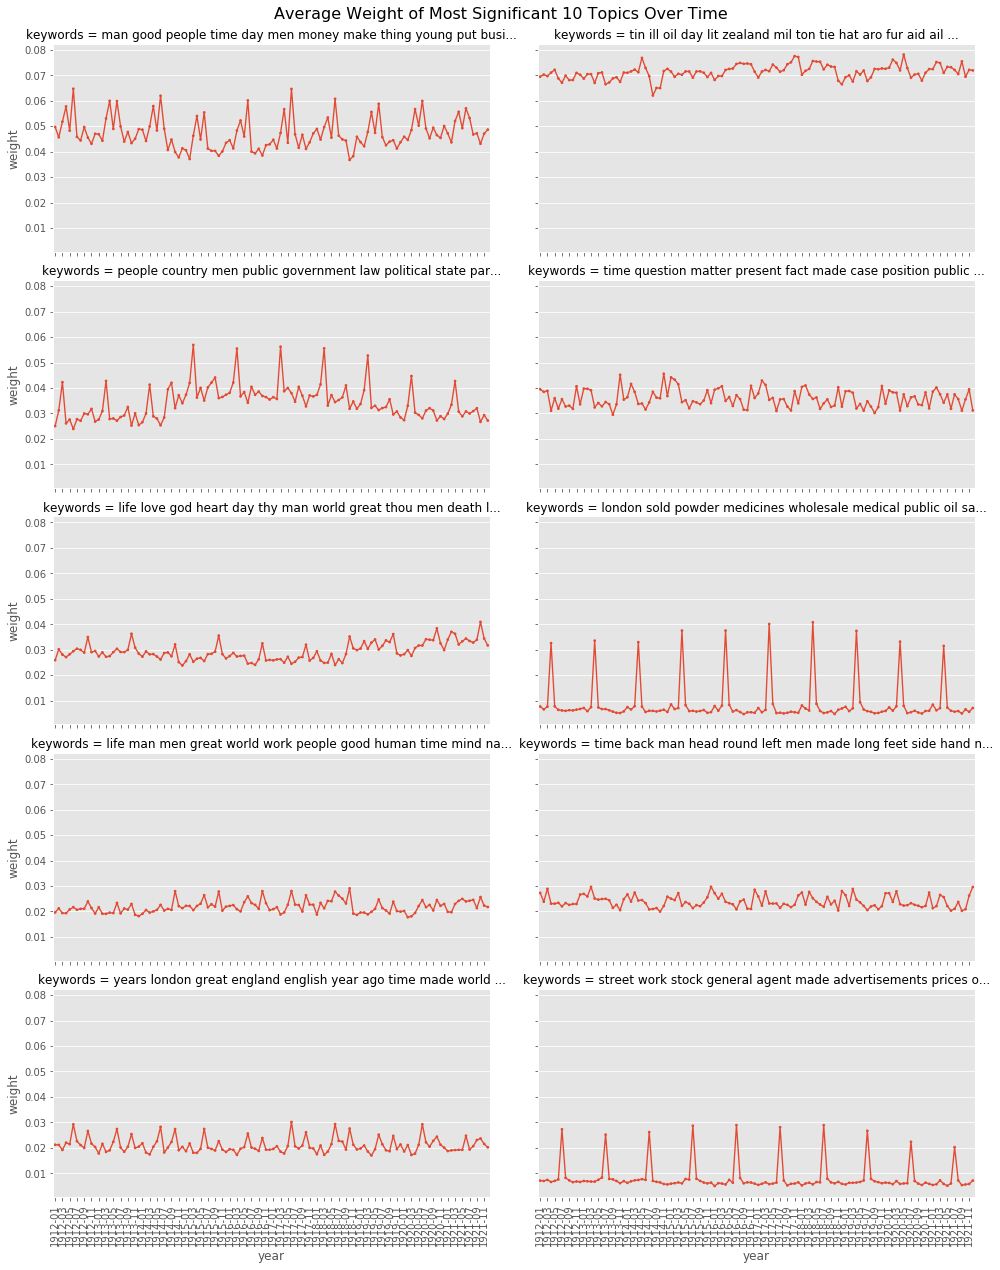

In [25]:
plot_topics(df_plt_avg, 
            'point', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

## 6 The Most Different Topics

**By compare the topic weight in topic list, we can find out which topics are the most different in WWI. Here we are interested in both trend (the more or less popular topics) in WWI.**

In [26]:
path = r'../models/wwi/topicKeysOthers.csv'

df_topics_others = (pd.read_csv(path, 
                                header=None, 
                                index_col=None, 
                                names = ['topic_', 'weight_', 'keywords_'],
                                encoding='utf8')
                    .sort_values(by='topic_')
                    .reset_index(drop=True))

df_diff = df_topics_others.join(df_topics)

# to find more populare topics
#df_diff['diff'] = (df_diff['weight'] - df_diff['weight_'])/(df_diff['weight'])
# to find more populare and contrary trend topics
df_diff['diff'] = abs(df_diff['weight'] - df_diff['weight_'])/(df_diff['weight'])

df_diff = df_diff.sort_values(by='diff', ascending=False)

topic_list = list(df_diff['topic'][:10])

print('List of topics to plot:', topic_list)

df_plt_dom = filter_topics(df_domtopic, topic_list)
df_plt_avg = filter_topics(df_avgweight, topic_list)

print('Shape of df_plt_dom:', df_plt_dom.shape)
print('Shape of df_plt_avg:', df_plt_avg.shape)

df_col_order = filter_topics(df_topics, topic_list).set_index('topic')
df_col_order = df_col_order.loc[topic_list]
col_order = df_col_order.keywords.str.slice(0,60)+'...'
df_col_order.head(10)

List of topics to plot: [126, 21, 34, 147, 109, 2, 185, 170, 46, 19]
Shape of df_plt_dom: (1668, 6)
Shape of df_plt_avg: (1200, 4)


,weight,keywords
topic,,
126,0.001930,association press telegraph received copyright london united electric cable sydney april march news australian octob...
21,0.001320,mails mail close office letters notices auckland united_kingdom post wellington chief late europe london fee due dai...
34,0.001224,weather rain wind winds heavy moderate hours strong barometer light gale to-day cape forecast breeze sea morning sou...
147,0.001422,south africa boers british general war transvaal boer london lord received african cape capetown troops contingent p...
109,0.001257,beat club played match play game championship won players tennis team games round wellington tournament matches satu...
2,0.000287,rooms price section bungalow deposit large modern home street garage kitchenette good sale post terms tram city view...
185,0.002491,wellington arrived nelson morning sailed auckland tons to-morrow port to-day lyttelton westport coast south picton l...
170,0.001270,team game play match football ball played good goal forwards rugby points wellington players scored saturday line ba...
46,0.001393,tons schooner cases barque melbourne agents passengers agent case port bags cargo early cutter sailed wellington lyt...


**Dominant topics distribution by month:**

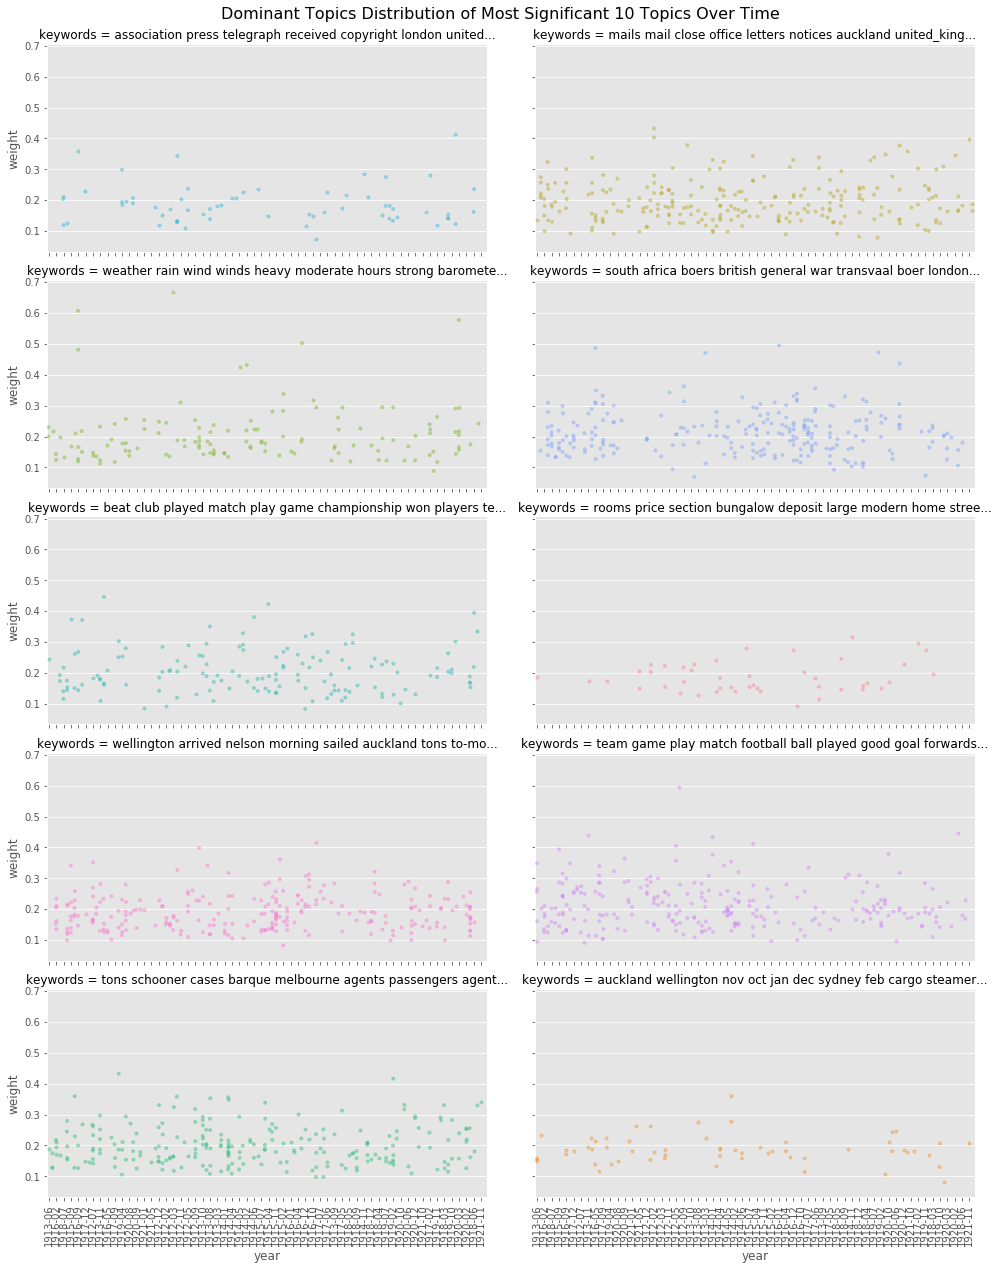

In [27]:
plot_topics(df_plt_dom, 
            'scatter', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

**Dominant topics count by month:**

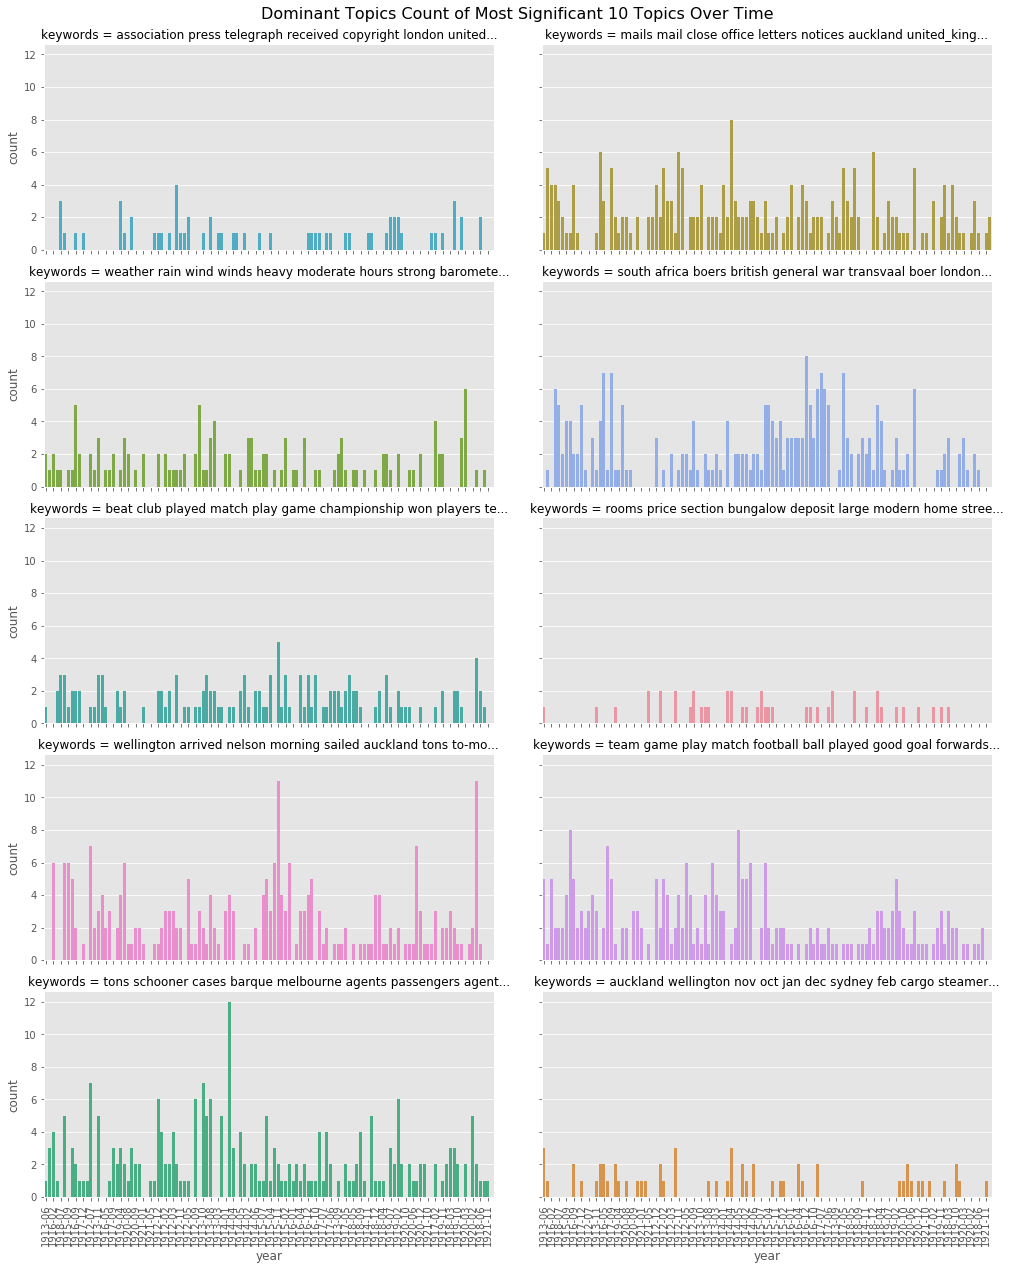

In [28]:
plot_topics(df_plt_dom, 
            'bar', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

**Average topic weight by month:**

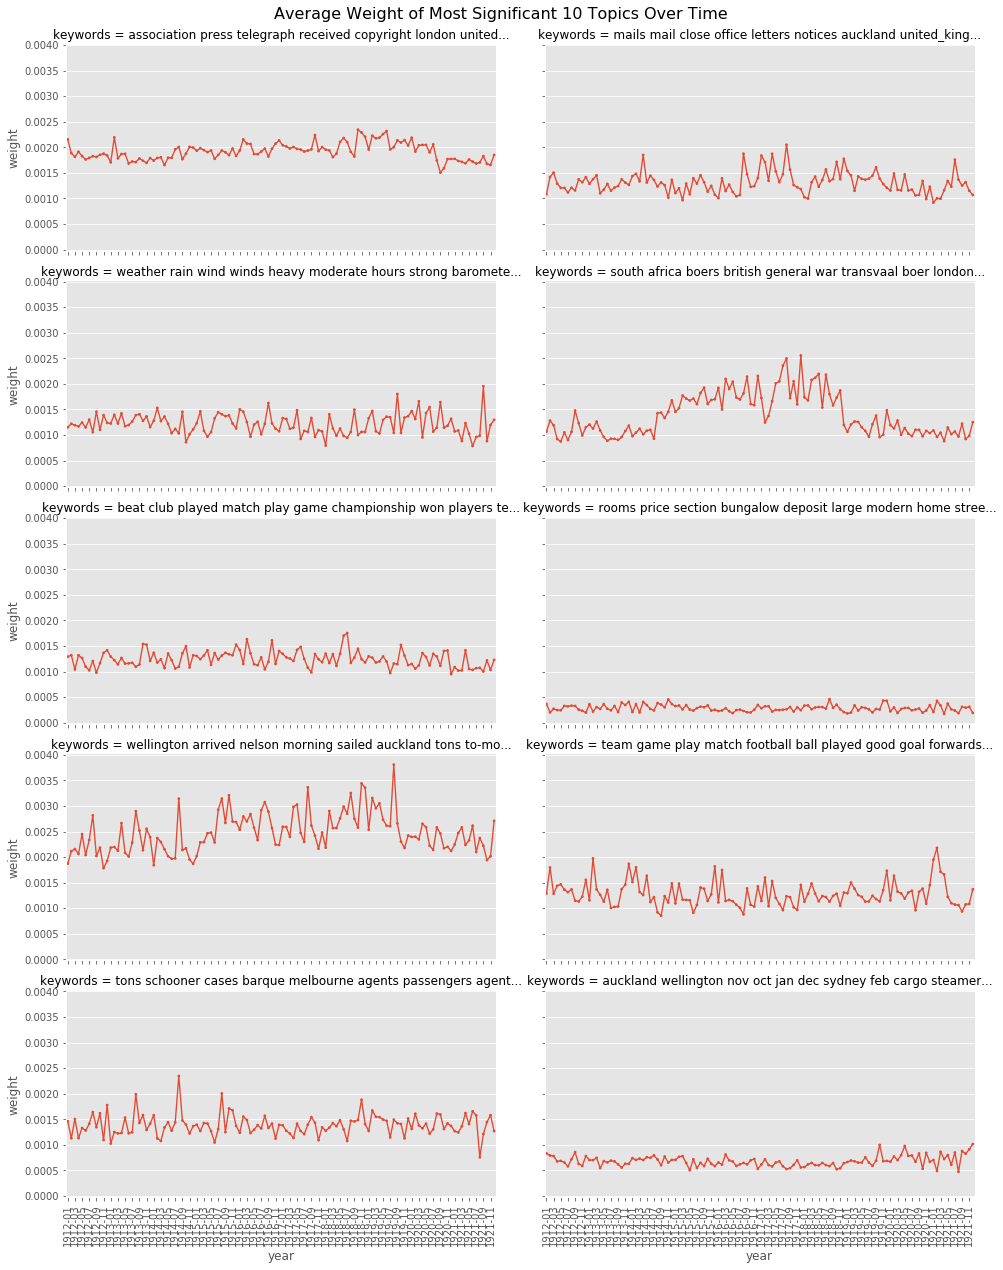

In [29]:
plot_topics(df_plt_avg, 
            'point', 
            col_order=col_order,
            adjust_top=0.95,
            title='Most Significant 10 Topics Over Time',
            height=3.5,
            col_wrap=2)

---

In [30]:
gc.collect()

215